In [1]:
import pandas as pd
import numpy as np
import json
from itertools import product
import matplotlib.pyplot as plt
from utils import calculate_NPV
plt.rcParams['text.usetex'] = True
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib.pyplot import MultipleLocator
font1 = {'weight' : 'bold',
    'size'   : 16,}
import os
from matplotlib.cm import ScalarMappable

# wind-battery ratio-duration price-taker (RT price, capacity factor errors fixed) vs double-loop sweeps.

In [2]:
# read double-loop results
def get_sweep_result(sweep_result_dict, data_type, year = 2023, scenario = "moderate", discount_rate = 0.05, OM_cost = True, curtailment = False):
    # at this batch, we can not get the dispatch information of battery and wind farm because the end simulaiton error.
    
    battery_duration_list = [2,4,6,8,10]
    pmax_ratio_list = [r/10 for r in range(1, 11, 1)]
    
    with open("wind_battery_cost_parameter.json", "rb") as f:
        price_dict = json.load(f)
    
    if data_type == "NPV":
        res_dict = {}
        for i in battery_duration_list:
            res_dict[i] = {}
            for j in range(1, 11, 1):
                annual_revenue = sweep_result_dict[str(i)][str(j)]["Total Revenue"]
                wind_size = 847
                battery_size = j/10*wind_size
                duration = i
                res_dict[i][j] = calculate_NPV(annual_revenue, wind_size, battery_size, duration, year, scenario, discount_rate, OM_cost, extant_wind = True)

        res_array = np.zeros((len(battery_duration_list),len(pmax_ratio_list)))

        for i in range(len(battery_duration_list)):
            for j in range(len(pmax_ratio_list)):
                res_array[i,j] = res_dict[battery_duration_list[i]][int(pmax_ratio_list[j]*10)]/1e6
    
    elif data_type == "Annual Elec Revenue":
        res_array = np.zeros((len(battery_duration_list),len(pmax_ratio_list)))
        for i in range(len(battery_duration_list)):
            for j in range(len(pmax_ratio_list)):
                res_array[i,j] = sweep_result_dict[str(battery_duration_list[i])][str(int(pmax_ratio_list[j]*10))]["Total Revenue"]/1e6
        
    elif data_type == "Annual Revenue":
        res_array = np.zeros((len(battery_duration_list),len(pmax_ratio_list)))
        for i in range(len(battery_duration_list)):
            for j in range(len(pmax_ratio_list)):
                elec_rev = sweep_result_dict[str(battery_duration_list[i])][str(int(pmax_ratio_list[j]*10))]["Total Revenue"]
                duration = battery_duration_list[i]
                wind_size = 847
                battery_size = pmax_ratio_list[j]*wind_size
                arg_duration = int(duration/2 - 1)
                batt_op_cost = price_dict["battery"]["fixed_om"][scenario][str(year)][arg_duration]
                wind_op_cost = price_dict["wind"]["fixed_om"][scenario][str(year)][0]
                net_rev = (elec_rev - wind_op_cost*wind_size*1000 - battery_size*batt_op_cost*1000)/1e6
                res_array[i,j] = net_rev
                
    elif data_type == "Dispatch":
        res_array = np.zeros((len(battery_duration_list),len(pmax_ratio_list)))
        for i in range(len(battery_duration_list)):
            for j in range(len(pmax_ratio_list)):
                dispatch = sweep_result_dict[str(battery_duration_list[i])][str(int(pmax_ratio_list[j]*10))]["Dispatch"]
                if curtailment == False:
                    res_array[i,j] = dispatch/1e6
                else:
                    res_array[i,j] = (2071980.6-dispatch)/1e6
                    
    elif data_type == "average_LMP":
        res_array = np.zeros((len(battery_duration_list),len(pmax_ratio_list)))
        for i in range(len(battery_duration_list)):
            for j in range(len(pmax_ratio_list)):
                res_array[i,j] = sweep_result_dict[str(battery_duration_list[i])][str(int(pmax_ratio_list[j]*10))]["average_LMP"] - 23.06
                    
    print(np.mean(res_array.reshape(-1)))
    
    x,y = np.meshgrid(battery_duration_list, pmax_ratio_list)

    return x, y, res_array

In [3]:
# Use a consistent colorbar. 

# calculate the max/min NPV
def calculate_Vmax_Vmin(summary_dict_1, summary_dict_2):
    
    Vmax = None
    Vmin = None
    for i in summary_dict_1:
        max_data = np.max([np.max(summary_dict_1[i]), np.max(summary_dict_2[i])])
        min_data = np.min([np.min(summary_dict_1[i]), np.min(summary_dict_2[i])])
        if not (Vmax or Vmin):
            Vmax = max_data
            Vmin = min_data
        if max_data >= Vmax:
            Vmax = max_data
        if min_data <= Vmin:
            Vmin = min_data
    
    return Vmax, Vmin

In [4]:
# plot contour

def plot_contour(summary_dict, Vmax, Vmin, cmap = 'viridis', color = 'k'):
    
    ratio_list = list(i/10 for i in range(1, 11))
    duration_list = [2,4,6,8,10]
    res_dict = {}

    data_res_array = np.zeros((len(duration_list),len(ratio_list)))

    for i in range(len(duration_list)):
        for j in range(len(ratio_list)):
            data_res_array[i,j] =summary_dict[duration_list[i]][j]/1e6

    x,y = np.meshgrid(duration_list, ratio_list)
    fig, ax = plt.subplots(figsize = (6,6))
    cs = ax.contourf(x, y, data_res_array.T, levels = 10, vmax = Vmax/1e6, vmin = Vmin/1e6, cmap = cmap)
#     cb = plt.colorbar(cs)
    
    x_major_locator = MultipleLocator(2)
    ax = plt.gca()
    ax.xaxis.set_major_locator(x_major_locator)
    
    cs_lines = ax.contour(x, y, data_res_array.T, levels=10, vmax = Vmax/1e6, vmin = Vmin/1e6, colors=color, alpha = 0.8)
    ax.clabel(cs_lines, inline = True, fontsize= 20)
    ax.set_xlabel('Battery Capacity [hr]', font = font1)
    ax.set_ylabel('Battery vs. Wind Power Ratio', font = font1)
    ax.tick_params(direction='in', top=True, right=True, labelsize = 15)
    
    return ax

### Use different colorbars with the same scale, plot electricity revenue

In [5]:
# price-taker electricity revenue
with open('pt_annual_elec_rev.json', 'rb') as f:    
    er_res = json.load(f)

# json convert int keys to strings. Convert them back to int.
pt_result_er = {}
for key in er_res:
    pt_result_er[int(key)] = er_res[key].copy()

In [6]:
# double-loop electricity revenue
result_json_path = "wind_battery_ratio_duration_rt_only_bidding.json"
with open(result_json_path, "rb") as f:
    dl_result = json.load(f)

# make it the same structure as price-taker results
dl_result_er = {}
for key in dl_result.keys():
    dl_result_er[int(key)] = []
    for j in range(1, 11):
        dl_result_er[int(key)].append(dl_result[key][str(j)]['Total Revenue'])

In [10]:
Vmax, Vmin = calculate_Vmax_Vmin(pt_result_er, dl_result_er)

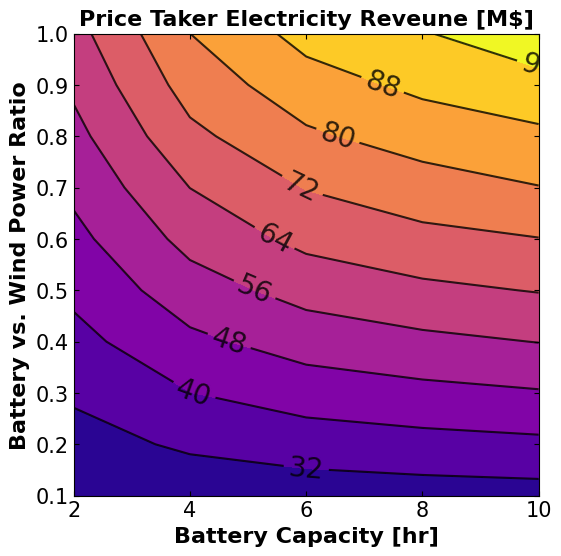

In [11]:
ax = plot_contour(pt_result_er, Vmax, Vmin, cmap = 'plasma')
# ax.scatter(2,0.1, c = 'r', linewidth = 10)
ax.set_title("Price Taker Electricity Reveune [M$]", font = font1)
plt.show()

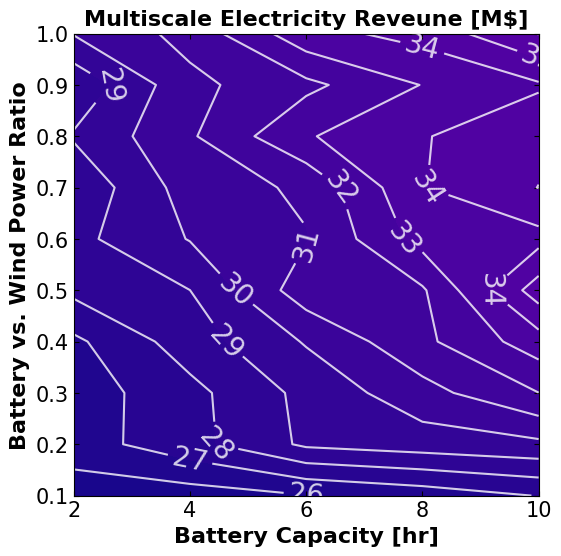

In [12]:
ax = plot_contour(dl_result_er, Vmax, Vmin, cmap = 'plasma', color = 'white')
ax.set_title("Multiscale Electricity Reveune [M$]", font = font1)
plt.show()

### Plot NPV

In [13]:
# calculate price-taker NPV
pt_result_npv = {}
for i in [2, 4, 6, 8, 10]:
    pt_result_npv[i] = []
    for j in range(1, 11):
        ratio = j/10
        pt_result_npv[i].append(calculate_NPV(pt_result_er[i][j-1], 847, ratio*847, i, 2023, "moderate", OM_cost = True, extant_wind = True))
# pt_result_npv

In [14]:
# read double-loop NPV
dl_result_npv = {}
for i in [2, 4, 6, 8, 10]:
    dl_result_npv[i] = []
    for j in range(1, 11):
        ratio = j/10
        dl_result_npv[i].append(calculate_NPV(dl_result_er[i][j-1], 847, ratio*847, i, 2023, "moderate", OM_cost = True, extant_wind = True))
# dl_result_npv

In [15]:
calculate_NPV(23570000, 847, 0*847, 0, 2023, "moderate", OM_cost = True, extant_wind = True)

-181666399.6023523

In [16]:
with open('wind_battery_cost_parameter.json', 'rb') as f:
    param = json.load(f)
# wind OM cost
print('O&M')
print('wind only', param['wind']['fixed_om']['moderate']['2023'][0]*1000*847)

# battery OM cost
print('2 hr', param['battery']['fixed_om']['moderate']['2023'][0]*847*1000)
print('10 hr', param['battery']['fixed_om']['moderate']['2023'][-1]*847*1000)

# Capex, Battery
print('Capex')
print('2hr', param['battery']['batt_cap_cost_param']['moderate']['2023'][0]*84.7*1000 + param['battery']['batt_cap_cost_param']['moderate']['2023'][1]*84.7*1000*2)
print('10 hr', param['battery']['batt_cap_cost_param']['moderate']['2023'][0]*847*1000 + param['battery']['batt_cap_cost_param']['moderate']['2023'][1]*847*1000*10)

O&M
wind only 35387660.0
2 hr 15797396.999999998
10 hr 58966446.0
Capex
2hr 63189164.50000001
10 hr 2358653605.0


In [17]:
Vmax, Vmin = calculate_Vmax_Vmin(pt_result_npv, dl_result_npv)

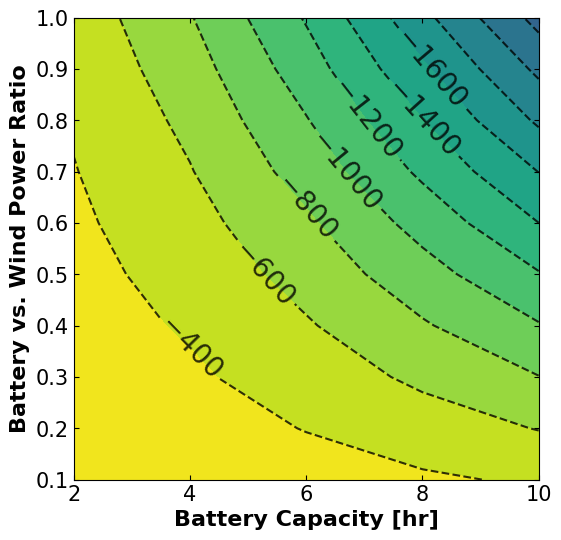

In [18]:
ax = plot_contour(pt_result_npv, Vmax, Vmin)
# ax.set_title("Price Taker NPV [M$]", font = font1)
plt.show()

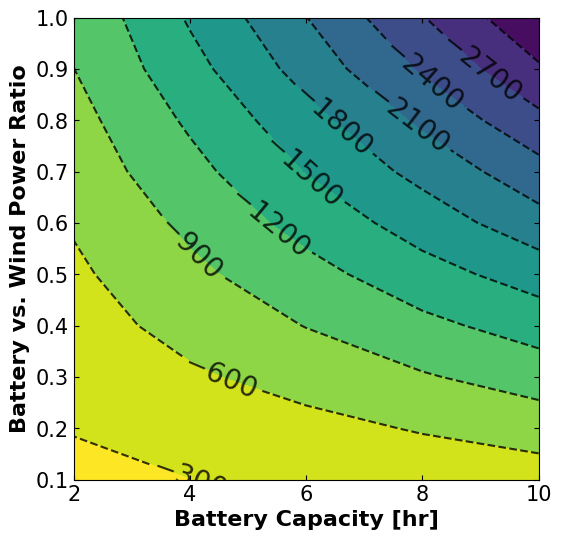

In [19]:
ax = plot_contour(dl_result_npv, Vmax, Vmin)
# ax.set_title("Multiscale Optimization NPV [M$]", font = font1)
plt.show()

## Delta between price-taker and double-loop

In [20]:
# difference in the electricity revenue
diff_er = {}
for i in dl_result_er.keys():
    diff_er[i] = []
    for j in range(len(dl_result_er[i])):
        diff_er[i].append(pt_result_er[i][j] - dl_result_er[i][j])
        
# diff_er

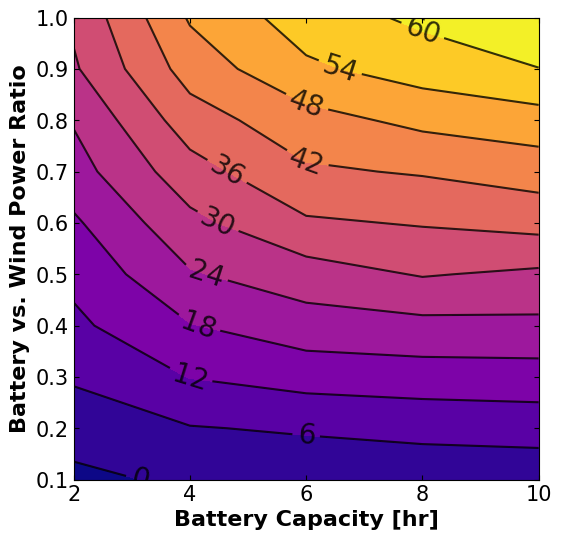

In [21]:
Vmax, Vmin = Vmax, Vmin = calculate_Vmax_Vmin(diff_er, diff_er)
ax = plot_contour(diff_er, Vmax, Vmin, cmap = 'plasma')
# ax.set_title("Difference in Electricity Revenue [M$]", font = font1)
# ax.set_xlabel('Battery Capacity [hr]', font = font1)
# ax.set_ylabel('Battery vs. Wind Power Ratio', font = font1)
plt.show()

In [23]:
# difference in the NPV
diff_npv = {}
for i in dl_result_npv.keys():
    diff_npv[i] = []
    for j in range(len(dl_result_npv[i])):
        diff_npv[i].append(pt_result_npv[i][j] - dl_result_npv[i][j])
# diff_npv

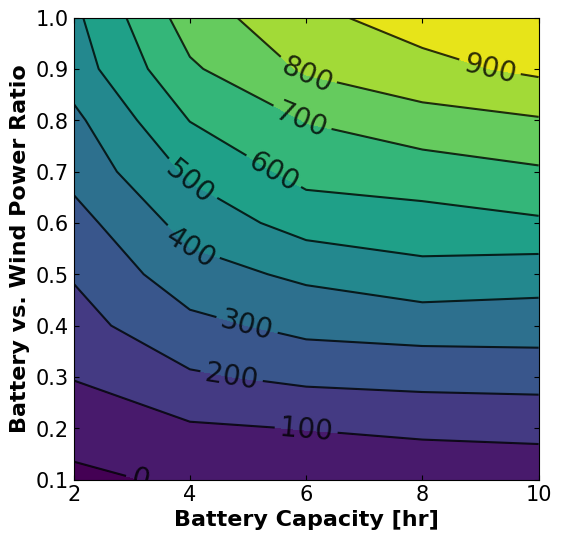

In [25]:
Vmax, Vmin = Vmax, Vmin = calculate_Vmax_Vmin(diff_npv, diff_npv)
ax = plot_contour(diff_npv, Vmax, Vmin)
# ax.set_title("Difference in NPV [M$]", font = font1)
# ax.set_xlabel('Battery Capacity [hr]', font = font1)
# ax.set_ylabel('Battery vs. Wind Power Ratio', font = font1)
plt.show()